### converting image to grayscale

In [2]:
# image manipulation
from skimage import io, img_as_float, color
from skimage.exposure import equalize_hist

In [3]:
# standard libs
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import math

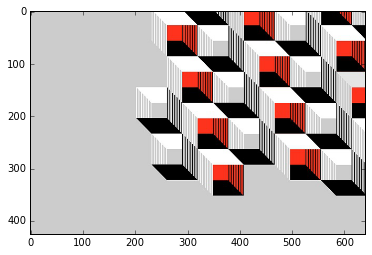

In [3]:
test_img_rgb = io.imread('./test_resized.jpg')
plt.imshow(test_img_rgb)
plt.show()

In [5]:
test_img_rgb[10,10]

array([204, 204, 204], dtype=uint8)

k, i was wrong the paper [here](https://inf.u-szeged.hu/~kato/papers/ivc2001.pdf), does use CIELUV colorspace, but that isn't grayscale.. it then does filtering to get a grayscale "feature image" .. maybe throw a gabor filter in here lol

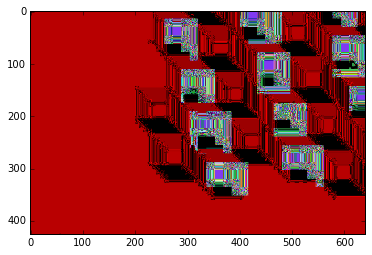

In [4]:
test_img_lab = color.rgb2lab(test_img_rgb)
plt.imshow(test_img_lab)
plt.show()

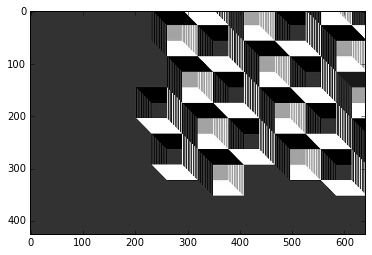

In [18]:
test_img_gray = color.rgb2gray(test_img_rgb)
plt.imshow(test_img_gray,cmap='gist_gray_r')
plt.show()

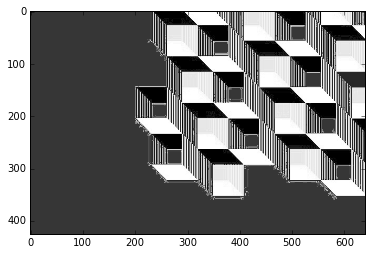

In [17]:
test_img_gray_norm = equalize_hist(test_img_gray)
plt.imshow(test_img_gray_norm,cmap='gist_gray_r')
plt.show()

throwaway testing random thing

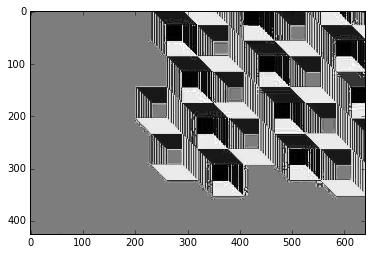

In [16]:
test_img_gray_lab_hist = equalize_hist(color.rgb2gray(test_img_lab))
plt.imshow(test_img_gray_lab_hist,cmap='gist_gray_r')
plt.show()

### mle to estimate pixel class given k-means/variances

In [21]:
means = [.3,.5,.7]
variances = [.25, .66, .25]

In [23]:
# since we will be comparing likelihoods can ignore the term that includes pi in it
def log_like(intensity, mu, sig):
    # sig is the variance (so in math-land it is actually sigma^2)
    return -0.5 * math.log(sig) - (intensity - mu)**2 / (2 * sig)

In [24]:
def estimate_class(data,i,j,mus,sigs):
#     assert len(mus) == len(sigs) # nah
    lls = [log_like(data[i,j],mus[k],sigs[k]) for k in range(len(mus))]
    return np.argmax(lls) # returns index of maximum as apposed to python's max which would return maximum value

In [25]:
estimate_class(test_img_gray_norm,10,10,means,variances)

2

In [30]:
def estimate_image(image,means,variances):
    (height, width) = np.shape(image) # color images only pls!!
    class_output = np.empty_like(image,dtype='int8')
    for i in range(height):
        for j in range(width):
            class_output[i,j] = estimate_class(image,i,j,means,variances)
            
    return class_output
            

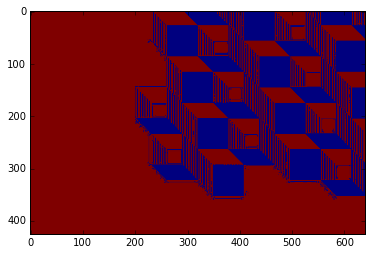

In [34]:
test_classes = estimate_image(test_img_gray_norm,means,variances)
plt.imshow(test_classes)
plt.show()

### vectorizing aka making stuff work with color

In [7]:
test_img_lab = img_as_float(test_img_lab) # no need to do this!
test_img_lab[10,10]

array([  8.20457817e+01,  -2.07496812e-03,   3.93317513e-03])

In [8]:
import random

In [10]:
means = [np.array([random.uniform(0,1),random.uniform(0,1),random.uniform(0,1) ]) for _ in range(3)]
means

[array([ 0.03965571,  0.70749873,  0.81744916]),
 array([ 0.94640537,  0.59347696,  0.34207173]),
 array([ 0.00287889,  0.46516699,  0.4242725 ])]

In [11]:
variance = random.uniform(0,1) * np.eye(3)
variance

array([[ 0.73715971,  0.        ,  0.        ],
       [ 0.        ,  0.73715971,  0.        ],
       [ 0.        ,  0.        ,  0.73715971]])

In [13]:
np.linalg.det(variance)
np.linalg.inv(variance)

array([[ 1.35655814,  0.        ,  0.        ],
       [ 0.        ,  1.35655814,  0.        ],
       [ 0.        ,  0.        ,  1.35655814]])

In [37]:
def log_like(i,j,label):
    x_mu = np.matrix(test_img_lab[i,j] - means[label])
    return 0.5 * (math.log(np.linalg.det(variance)) + x_mu * np.linalg.inv(variance) * x_mu.T)

In [39]:
[log_like(10,10,k) for k in range(3)]

[matrix([[ 4561.76289381]]),
 matrix([[ 4460.97595425]]),
 matrix([[ 4565.33260873]])]

In [23]:
x = test_img_lab[10,10]
((x - means[0]).transpose())* np.linalg.inv(variance) * (x - means[0])

array([[  9.12285984e+03,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   6.83020008e-01,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   8.97781379e-01]])

In [25]:
xd = (x - means[0])

In [34]:
np.matrix(x-means[0]) * np.linalg.inv(variance) * np.matrix(x-means[0]).T

matrix([[ 9124.44063975]])

In [3]:
cg = io.imread('./1480542094753.png')

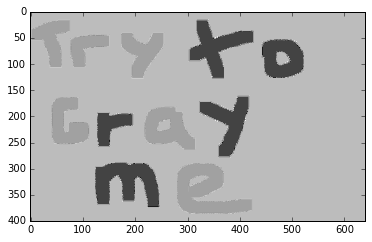

In [7]:
cg = color.rgb2gray(cg)
plt.imshow(cg,cmap='gray')
plt.savefig('okay.png')

In [6]:
io.imsave(cg,'./okay.png')

KeyError: <class 'numpy.str_'>

In [10]:
test_m = [np.matrix([[ 4561.76289381]]),
 np.matrix([[ 4460.97595425]]),
 np.matrix([[ 4565.33260873]])]

In [13]:
test_m[0].item(0)

4561.76289381

In [24]:
class Image():
	"""
	holds a picture
	can either supply a filename or
	data as a numpy array
	"""
	def __init__(self, filename=None, data=None):
		assert any([filename is not None, data is not None]), "you need to supply an image file or pass a picture array"

		if filename is not None:
			self._data = io.imread(filename)
		else:
			self._data = data

		# preprocessing
		self._data = color.rgb2lab(self._data)
		# if self._data.ndim > 2:
		# 	self._data = equalize_hist(color.rgb2gray(self._data)) # convert to grayscale
		# self._data = img_as_float(self._data) # lab already normalized??

		(self.height, self.width, self.bitdepth) = self._data.shape

		self.indices = [(i,j) for i in range(self.height) for j in range(self.width)]


	def __getitem__(self, item):
	# piggyback off of numpy's array indexing
		return self._data.__getitem__(item)

In [26]:
test_img = Image('./test_resized_2.jpg')
means = [np.array([random.uniform(0,1),random.uniform(0,1),random.uniform(0,1) ]) for _ in range(3)]
variances = [random.uniform(0,1) * np.eye(3),random.uniform(0,1) * np.eye(3),random.uniform(0,1) * np.eye(3) ]


In [35]:
var_dets = np.array([np.linalg.det(variances[k]) for k in range(3)])
var_invs = np.array([np.linalg.inv(variances[k]) for k in range(3)])
var_invs

array([[[ 1.60295012,  0.        ,  0.        ],
        [ 0.        ,  1.60295012,  0.        ],
        [ 0.        ,  0.        ,  1.60295012]],

       [[ 1.48808801,  0.        ,  0.        ],
        [ 0.        ,  1.48808801,  0.        ],
        [ 0.        ,  0.        ,  1.48808801]],

       [[ 6.23099949,  0.        ,  0.        ],
        [ 0.        ,  6.23099949,  0.        ],
        [ 0.        ,  0.        ,  6.23099949]]])

In [36]:
x_mu = np.matrix(test_img[10,10] - means[0])
x_mu

matrix([[ 81.24317866,  -0.65176448,  -0.50863467]])

In [37]:
(0.5 * (math.log(var_dets[0]) + x_mu * var_invs[0] * x_mu.T)).item(0) # unwrap numpy matrix

5289.939373403306

In [4]:
mu_init = np.random.rand(2,3)

In [5]:
mu_init[0]

array([ 0.21471524,  0.25826849,  0.83060011])

In [10]:
sigma_init = [np.eye(3) * random.uniform(0,1)] * 3

In [9]:
import random

In [11]:
sigma_init[0]

array([[ 0.91183252,  0.        ,  0.        ],
       [ 0.        ,  0.91183252,  0.        ],
       [ 0.        ,  0.        ,  0.91183252]])

In [1]:
import matplotlib.image as mpimg
from scipy import misc

In [23]:
test_img = misc.imresize(mpimg.imread("./test.jpg"),2.5)/255
test_img.shape

(3187, 4800, 3)

In [20]:
io.imread('./test_resized_2.jpg')/255

array([[[ 0.8       ,  0.8       ,  0.8       ],
        [ 0.8       ,  0.8       ,  0.8       ],
        [ 0.8       ,  0.8       ,  0.8       ],
        ..., 
        [ 0.85098039,  0.81568627,  0.78039216],
        [ 0.80784314,  0.83921569,  0.78039216],
        [ 0.76470588,  0.87843137,  0.79215686]],

       [[ 0.8       ,  0.8       ,  0.8       ],
        [ 0.8       ,  0.8       ,  0.8       ],
        [ 0.8       ,  0.8       ,  0.8       ],
        ..., 
        [ 0.83137255,  0.8       ,  0.79215686],
        [ 0.81568627,  0.81960784,  0.8       ],
        [ 0.80392157,  0.8627451 ,  0.83529412]],

       [[ 0.8       ,  0.8       ,  0.8       ],
        [ 0.8       ,  0.8       ,  0.8       ],
        [ 0.8       ,  0.8       ,  0.8       ],
        ..., 
        [ 0.82745098,  0.8       ,  0.83137255],
        [ 0.81568627,  0.80392157,  0.83921569],
        [ 0.83137255,  0.84705882,  0.88235294]],

       ..., 
       [[ 0.8       ,  0.8       ,  0.8       ],
        

In [24]:
sigma_init[0][1]

array([ 0.        ,  0.91183252,  0.        ])

### proofs
[notes](http://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_histo_segmentation.html#example-plot-histo]-segmentation-py)

In [4]:
import matplotlib.image as mpimg
from scipy import misc

In [13]:
mini = misc.imresize(mpimg.imread("./watershed.png"),5)

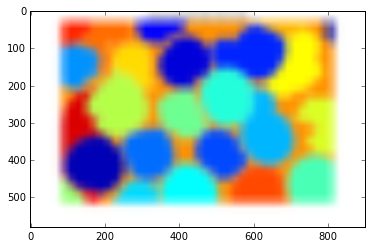

In [31]:
plt.imshow(misc.imresize(mini,2000))

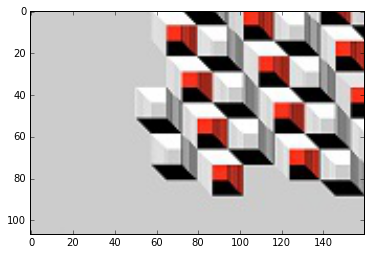

In [29]:
mytest = io.imread('./test_resized_2.jpg')
plt.imshow(mytest)

In [11]:
def hexencode(rgb):
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    return '#%02x%02x%02x' % (r,g,b)


In [27]:
hist, bin_edges = np.histogram(mini, bins=100)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])


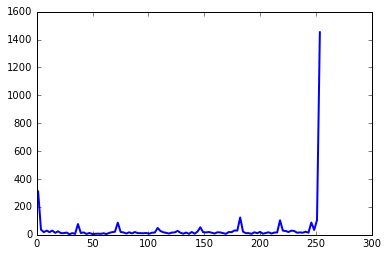

In [28]:
plt.plot(bin_centers, hist, lw=2)


i see 8 distinct colors

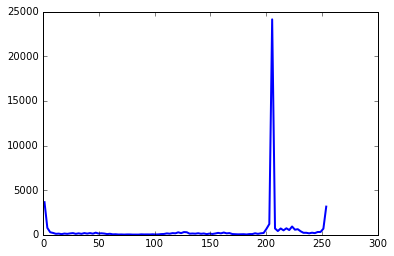

In [30]:
hist, bin_edges = np.histogram(mytest, bins=100)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)


only 3 distinct ones here

In [39]:
from gmm import GMM

In [42]:
test_gmm = GMM(dim=3, ncomps=3, data=mini,method='kmeans')

ValueError: Input of rank > 2 not supported

In [41]:
test_gmm.em(mini,100)

AttributeError: 'GMM' object has no attribute 'priors'